In [1]:
from pathlib import Path
import random
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File
import pandas as pd

from bayes_opt import BayesianOptimization
from pomegranate import NormalDistribution, BetaDistribution, GeneralMixtureModel

from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from nanoepitools.math import llr_to_p, p_to_llr
from benchmark_pycometh.config import module_config
from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader

In [2]:
def estimate_beta_dist(x):
    mean = np.mean(x)
    var = np.var(x)
    alpha = ((1-mean) / var - 1/mean) *  mean**2
    beta = alpha * (1/mean - 1)
    return alpha, beta

In [3]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})

Fasta(module_config.reference)

Fasta("/home/r933r/data/resource/human/hg38/Ensembl_101/Homo_sapiens.GRCh38.dna.primary_assembly.fa")

In [4]:
mf = MetH5File(module_config.meth5_template_file.format(sample="HG002"), "r")

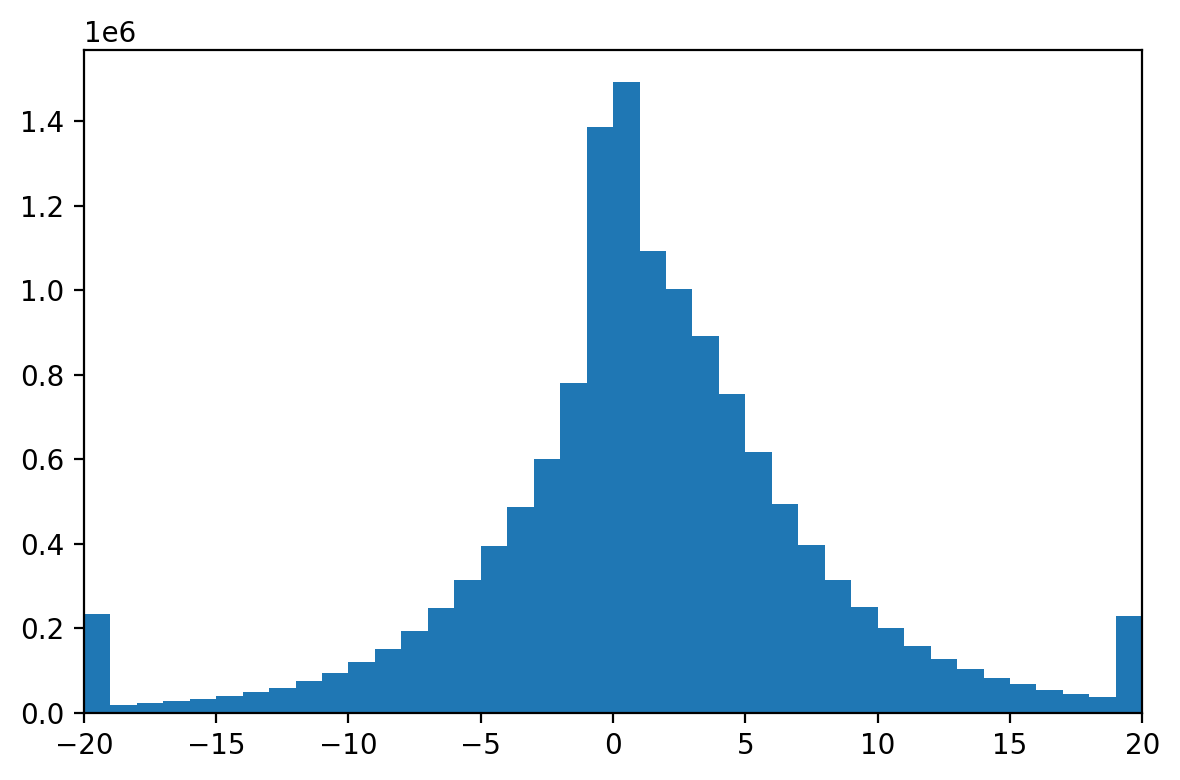

In [5]:
llrs = mf["21"].get_all_values().get_llrs()

pa.figure()
plt.hist(np.clip(llrs, -20, 20), bins=40)
plt.xlim(-20,20)
plt.show()

/home/r933r/code/nanoepitools/nanoepitools/math.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-llr) * (1 / prior - 1))


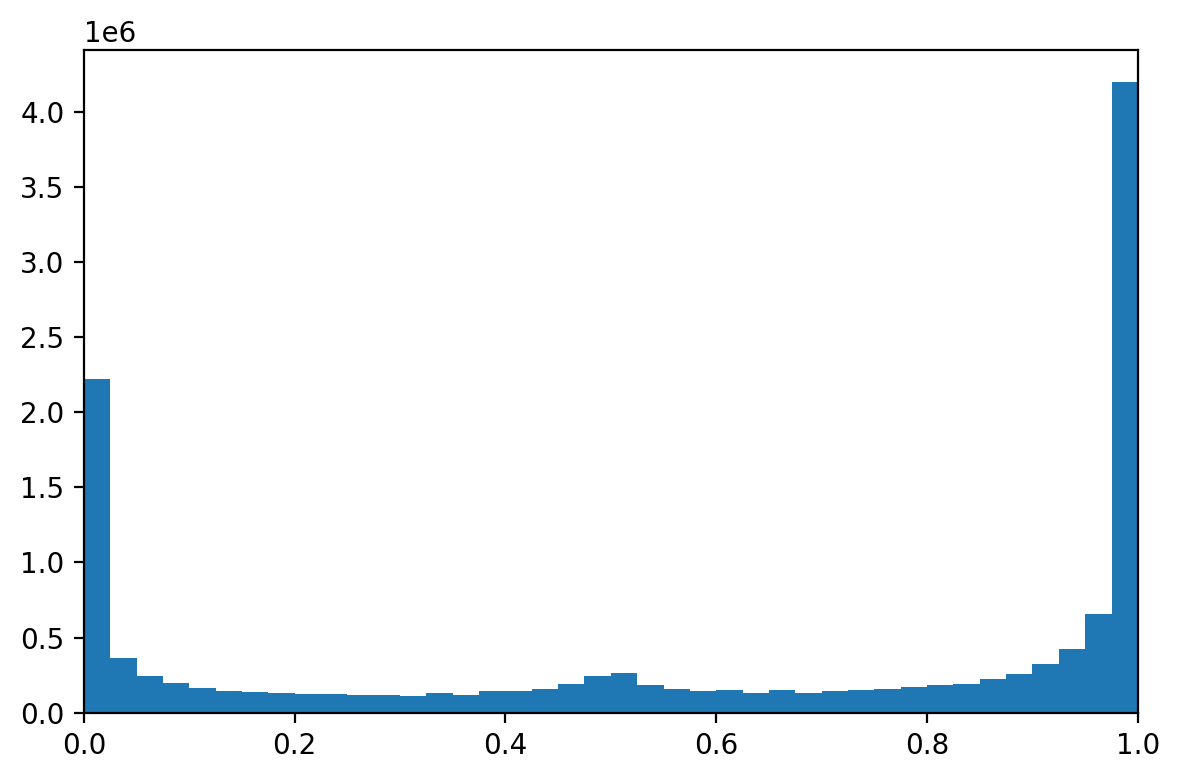

In [6]:
ps = llr_to_p(llrs)

pa.figure()
plt.hist(ps, bins=40)
plt.xlim(0,1)
plt.show()

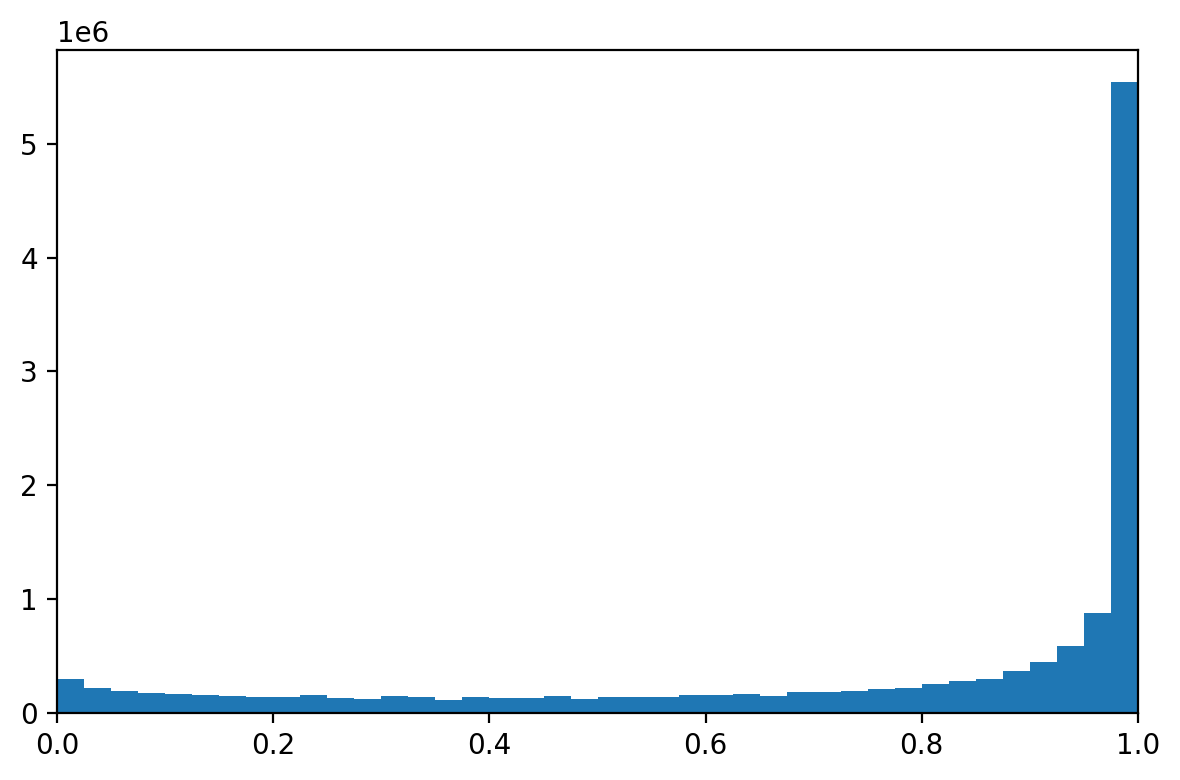

In [7]:
pa.figure()
plt.hist(np.abs(ps*2-1), bins=40)
plt.xlim(0,1)
plt.show()

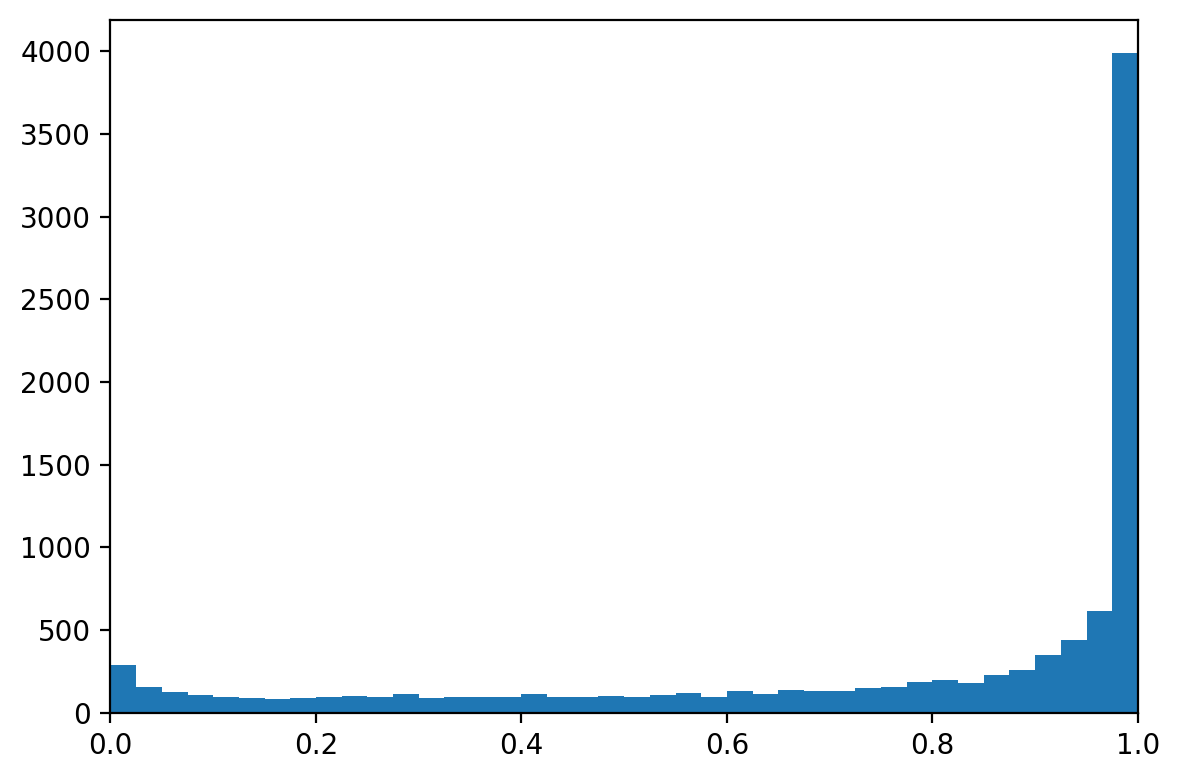

In [8]:
s = np.random.beta(*estimate_beta_dist(np.abs(ps*2-1)), 10000)
pa.figure()

plt.xlim(0,1)
plt.show()


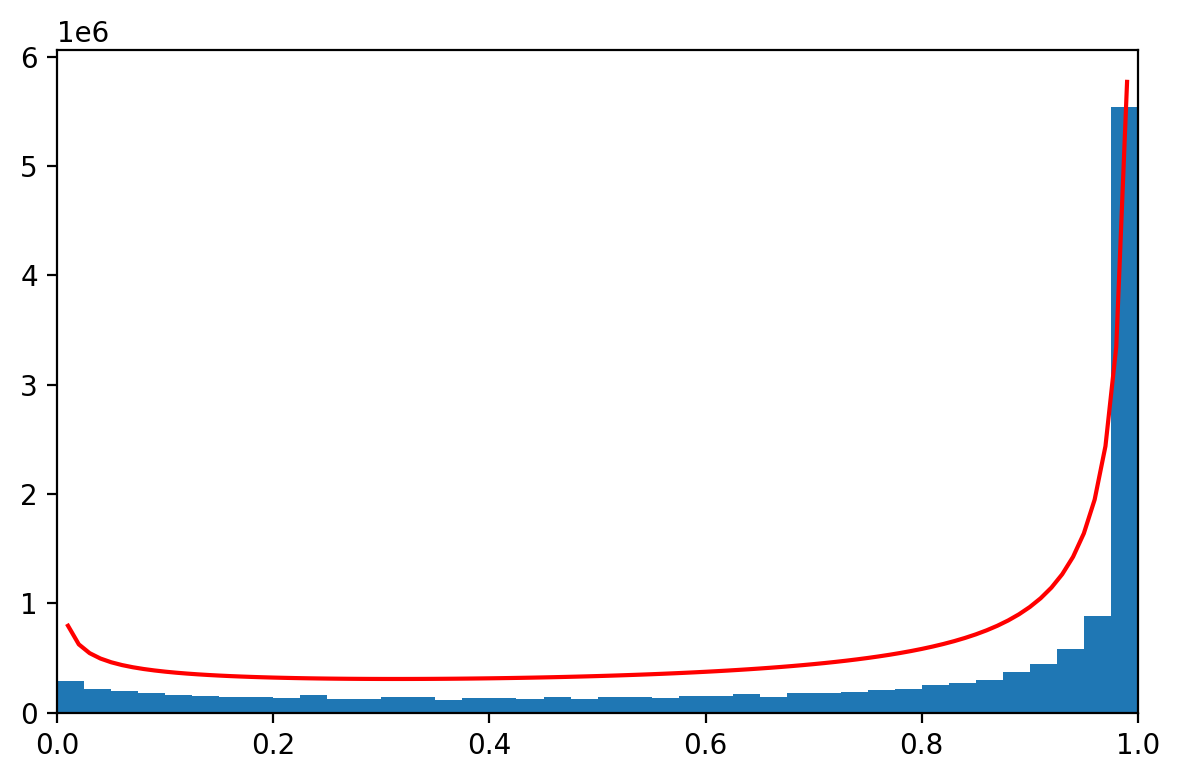

In [31]:
import scipy.stats
alpha, beta = estimate_beta_dist(np.abs(ps*2-1))
x = np.arange(0.01,1,0.01)
pred = scipy.stats.beta(alpha, beta).pdf(x)
pa.figure()
plt.hist(np.abs(ps*2-1), bins=40)
plt.plot(x, pred / 7 * plt.ylim()[1], c = "red")
plt.xlim(0,1)
pa.saveandshow("parameter_quality")

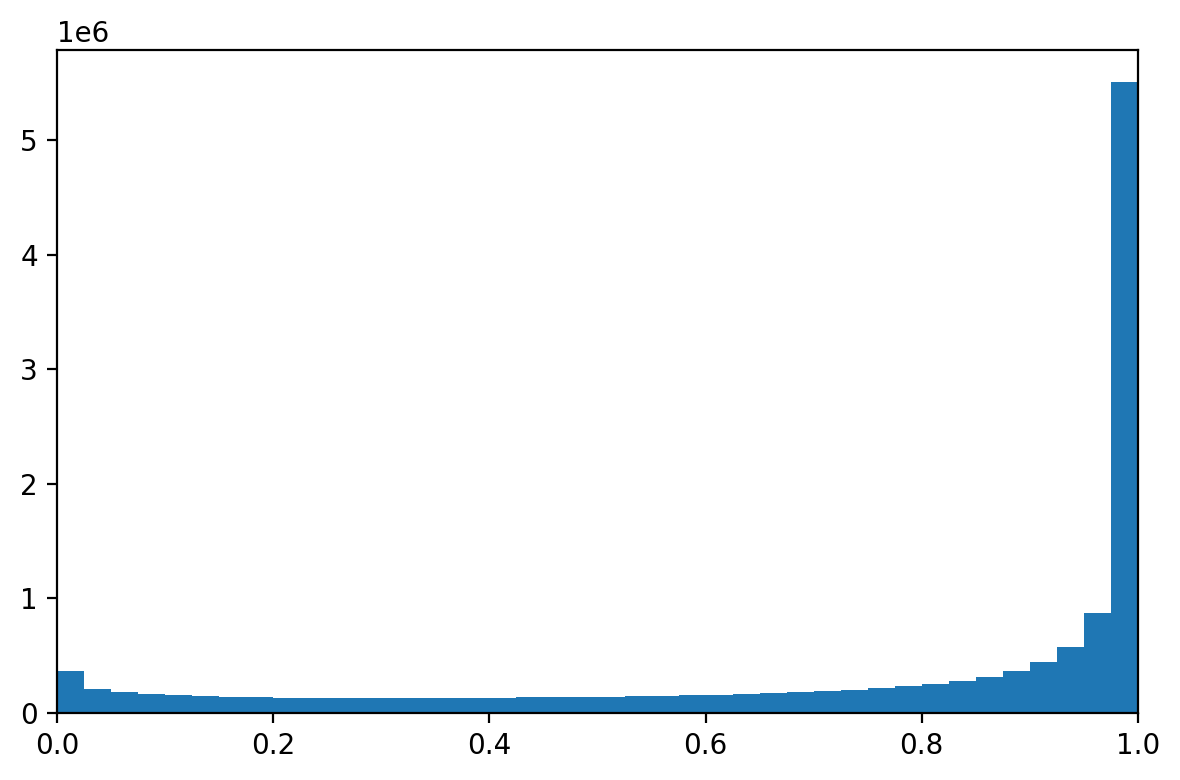

In [25]:
import scipy.stats
alpha, beta = estimate_beta_dist(np.abs(ps*2-1))
pred = np.random.beta(alpha,beta, len(ps))
pa.figure()
plt.hist(pred, bins=40)
plt.xlim(0,1)
plt.show()

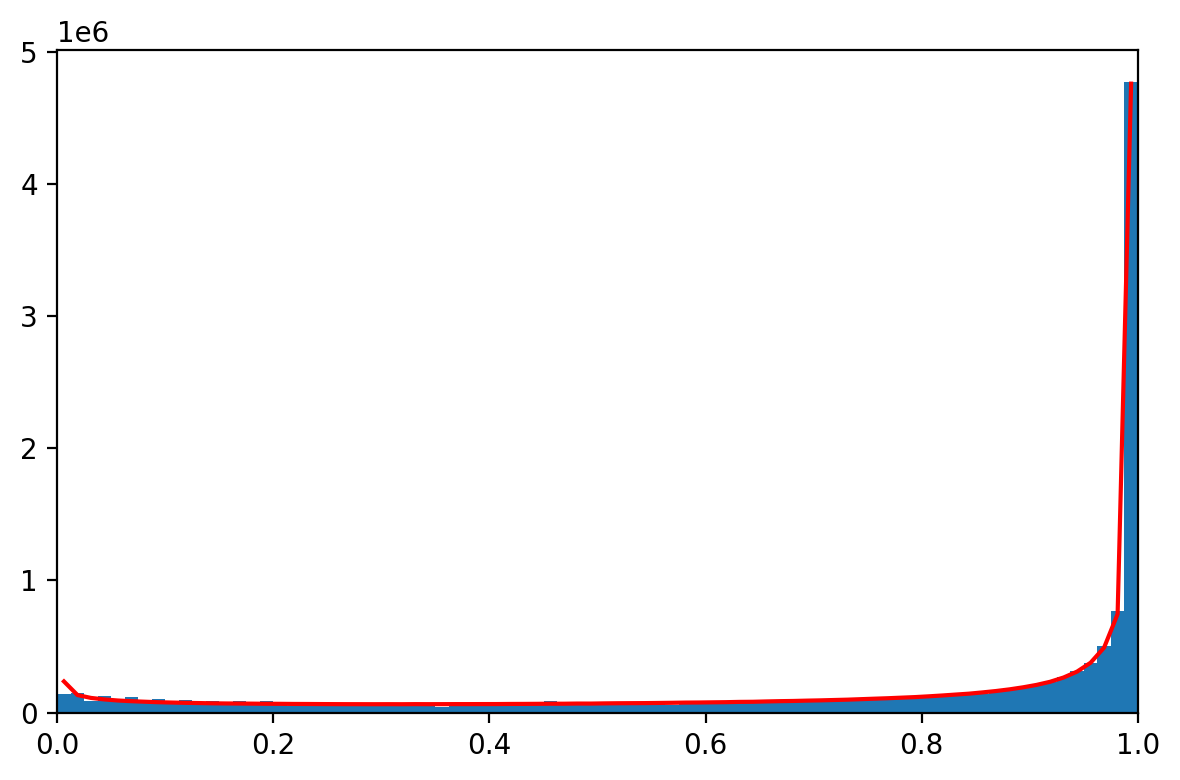

In [49]:
pred = np.random.beta(alpha,beta, len(ps))
predh, x = np.histogram(pred, bins=80)
pa.figure()
plt.hist(np.abs(ps*2-1), bins=80)
plt.plot(x[0:-1] + np.diff(x)/2, predh , c = "red")
plt.xlim(0,1)
plt.show()

In [53]:
beta

0.2087560635785752

In [ ]:
omics_simla_dir = Path("/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/unmetbig")
omics_simla_profile_path = Path("/home/r933r/data/software/users/snajder/OmicsSIMLA_v0.6/profiles/methylation/WGBS/liver_profile.txt")
omics_simla_profile_map_path = Path("/home/r933r/data/software/users/snajder/OmicsSIMLA_v0.6/profiles/methylation/WGBS/map.txt")

sim = OmicsSimlaLoader(omics_simla_dir, omics_simla_profile_path, omics_simla_profile_map_path)



In [ ]:
for sample in sim.rates:
    sim.summary[sample] = sim.rates[sample]

sim.summary["segment_rate"] = sim.profile_rates

In [ ]:

pa.figure()
plot_2d_density(np.array(sim.profile_rates), np.array(sim.summary["DCONTROLS1"]), cmap="jet")
plt.gca().set_aspect("equal")
plt.plot([0,1],[0,1])
plt.show()

pa.figure()
plot_2d_density(np.array(sim.profile_rates), np.array(sim.summary["DCASES1"]), cmap="jet")
plt.gca().set_aspect("equal")
plt.plot([0,1],[0,1])
plt.show()

In [ ]:
idx = np.array(sim.summary["Theta"] < 0) & (sim.segment_types == 1)
pa.figure()
plot_2d_density(np.array(sim.summary["DCONTROLS1"])[idx], np.array(sim.summary["DCASES1"])[idx], cmap="jet", nbins=100)
plt.gca().set_aspect("equal")
plt.plot([0,1],[0,1])
plt.show()

pa.figure()
plot_2d_density(sim.profile_rates[idx], np.array(sim.summary["DCASES1"])[idx], cmap="jet", nbins=100)
plt.gca().set_aspect("equal")
plt.plot([0,1],[0,1])
plt.show()

In [54]:
def read_fq_read_lengths(fq_files, minlen=100):
    for fq_file in fq_files:
        with open(fq_file, "r") as f:
            while True:
                try:
                    _ = next(f) # header
                    seq = next(f) # seq
                    _ = next(f) # header
                    _ = next(f) # qual
                    l = len(seq)
                    if l > minlen:
                        yield l
                except StopIteration:
                    break

fq_dir = "/home/r933r/data/projects/nanopore/pycometh_benchmark/fastq/HG002/"
batches = [f"{fq_dir}/{i}.fq" for i in range(20)]
read_lens = list(read_fq_read_lengths(batches))

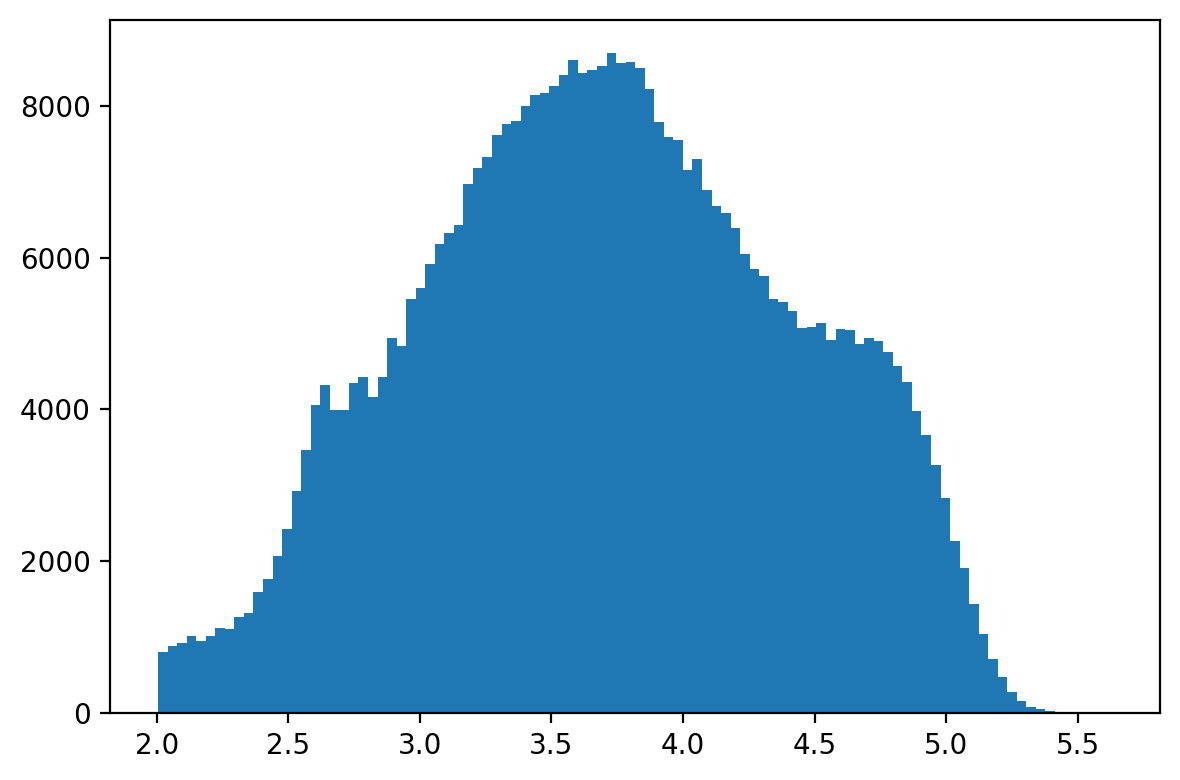

In [55]:
pa.figure()
plt.hist(np.log10(read_lens), bins=100)
plt.show()

In [56]:
readlen_model = GeneralMixtureModel([NormalDistribution(3,0.5), NormalDistribution(4,0.5), NormalDistribution(5,0.5)])
readlen_model.fit(np.log10(read_lens))

{
    "class" : "GeneralMixtureModel",
    "distributions" : [
        {
            "class" : "Distribution",
            "name" : "NormalDistribution",
            "parameters" : [
                2.88291094255057,
                0.388494435583139
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "NormalDistribution",
            "parameters" : [
                3.791129758134182,
                0.48033132778897775
            ],
            "frozen" : false
        },
        {
            "class" : "Distribution",
            "name" : "NormalDistribution",
            "parameters" : [
                4.750982560643743,
                0.21885599097577174
            ],
            "frozen" : false
        }
    ],
    "weights" : [
        0.23009969211866357,
        0.6338073264506189,
        0.13609298143071766
    ]
}

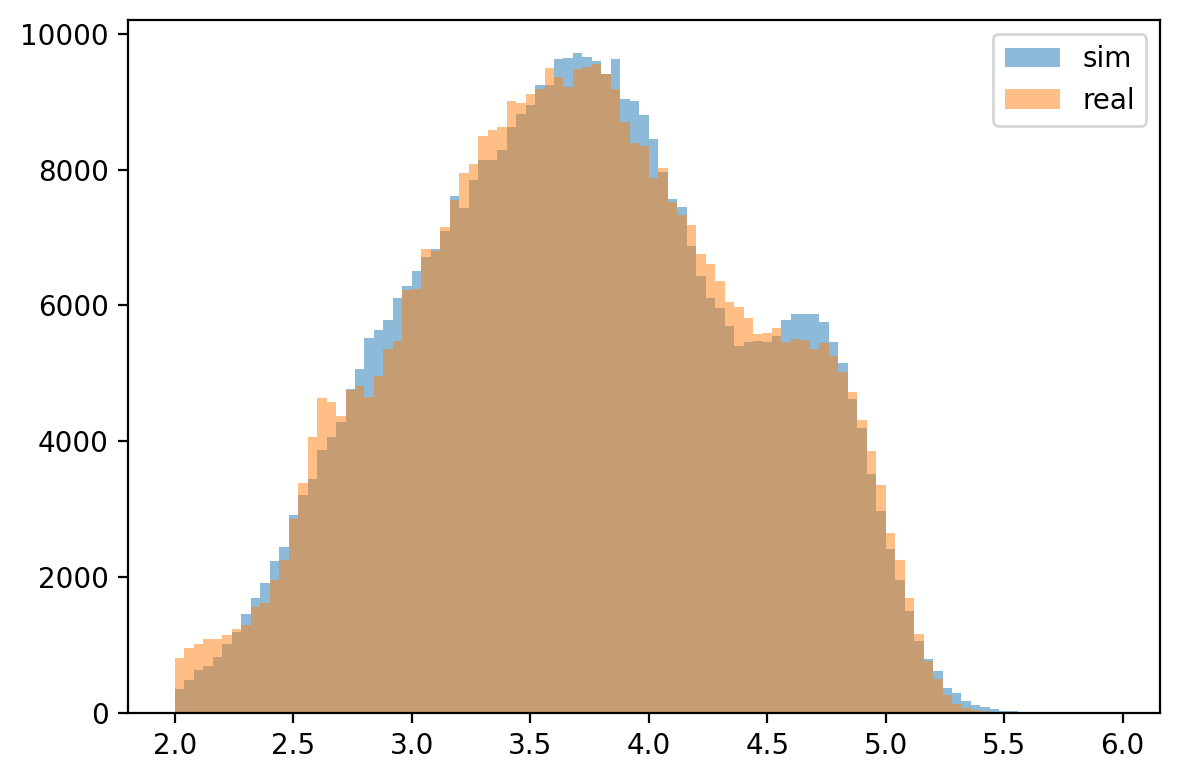

In [62]:
#s = readlen_model.sample(len(read_lens))
pa.figure()
bins = np.arange(2, 6, 0.04)
plt.hist(s, bins=bins, alpha=0.5, label="sim")
plt.hist(np.log10(read_lens), bins=bins, alpha=0.5, label="real")
plt.legend()
plt.show()